In [3]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
from datetime import date,datetime
import logging

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch import optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
def show(img):
    """
    用来显示图片的
    """
    plt.figure(figsize=(12, 8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## 加载数据

In [5]:
batch_size = 100

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## 定义网络

In [62]:
# 定义网络
class DeepAutoEncoder(nn.Module):
    def __init__(self):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
        ) # encoder可以将图片大小转换为 1*28*28 -> 6*2*2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, bias=False), # 1->4
            nn.BatchNorm2d(6),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, bias=False), # 1->4
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=2, bias=False), # 4 -> 10
            nn.BatchNorm2d(3),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=2, stride=1, bias=False), # 10 -> 22
            nn.BatchNorm2d(1),
            # nn.Tanh()
        ) # decoder可以将图片大小转换为 6*2*2 -> 1*28*28
        
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

In [63]:
AE = DeepAutoEncoder().to(device) # 定义分类器

# 进行测试
for i, (datas, labels) in enumerate(train_loader):
    datas = datas.to(device)
    x = AE(datas)
    print(x.shape)
    break

torch.Size([100, 1, 28, 28])


## 开始训练

In [64]:
# ----------
# 初始化网络
# ----------
AE = DeepAutoEncoder().to(device) # 定义分类器
# ------------
# 定义损失函数
# ------------
criterion = nn.L1Loss()
# -----------------------
# 定义损失函数和优化器
# -----------------------
learning_rate = 0.0005
optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)

lossList = []

# ---------
# 开始训练
# ---------
num_epochs = 20
total_step = len(train_loader) # 依次epoch的步骤
# 开始训练
for epoch in range(num_epochs):
    totalLoss = 0 # 总的误差
    for i, (images, _) in enumerate(train_loader):
        batch_size = images.size(0)
        images = images.to(device)
        # ---------------------
        # 开始训练discriminator
        # ---------------------
        AE.train()
        # 首先计算真实的图片
        fake_image = AE(images) # 计算重构之后的内容
        loss = criterion(images, fake_image) # 计算loss
        optimizer.zero_grad() # 优化器梯度都要清0
        loss.backward() # 反向传播
        optimizer.step() # 进行优化

        totalLoss = totalLoss + loss.item()
        # ---------
        # 打印结果
        # ---------
        if (i+2) % 280 == 0:
            t = datetime.now() #获取现在的时间
            print('Time {}, Epoch [{}/{}], Step [{}/{}], loss:{:.4f}'.format(t, epoch, num_epochs, i+1, total_step, totalLoss/(i+1)))
    lossList.append(totalLoss/(i+1))

Time 2020-07-16 14:11:44.117958, Epoch [0/20], Step [279/600], loss:0.2607
Time 2020-07-16 14:11:50.683520, Epoch [0/20], Step [559/600], loss:0.2092
Time 2020-07-16 14:11:58.201007, Epoch [1/20], Step [279/600], loss:0.1425
Time 2020-07-16 14:12:04.780550, Epoch [1/20], Step [559/600], loss:0.1366
Time 2020-07-16 14:12:12.355482, Epoch [2/20], Step [279/600], loss:0.1187
Time 2020-07-16 14:12:18.901407, Epoch [2/20], Step [559/600], loss:0.1146
Time 2020-07-16 14:12:26.373156, Epoch [3/20], Step [279/600], loss:0.1016
Time 2020-07-16 14:12:32.980126, Epoch [3/20], Step [559/600], loss:0.0991
Time 2020-07-16 14:12:40.480678, Epoch [4/20], Step [279/600], loss:0.0919
Time 2020-07-16 14:12:47.070258, Epoch [4/20], Step [559/600], loss:0.0901
Time 2020-07-16 14:12:54.612072, Epoch [5/20], Step [279/600], loss:0.0853
Time 2020-07-16 14:13:01.176781, Epoch [5/20], Step [559/600], loss:0.0842
Time 2020-07-16 14:13:08.649869, Epoch [6/20], Step [279/600], loss:0.0808
Time 2020-07-16 14:13:15.

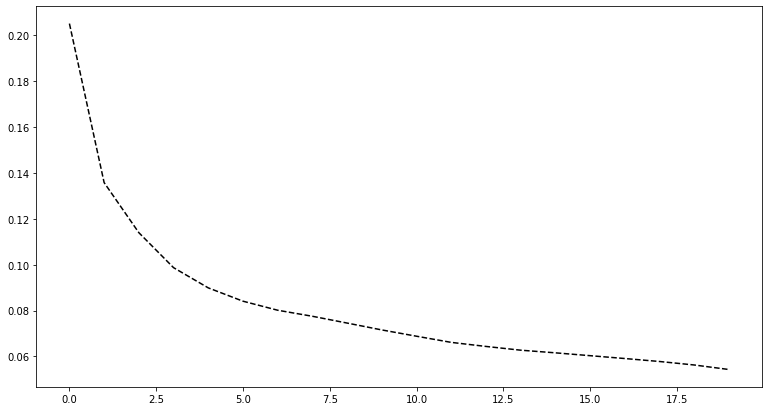

In [65]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(lossList, 'k--')

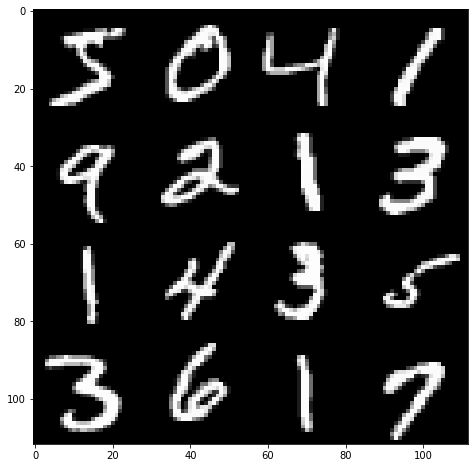

In [66]:
# 查看重构的图像
T_images = torch.stack(([train_dataset[i][0] for i in range(16)]))
show(make_grid(T_images, nrow=4, padding=0, normalize=True, range=None, scale_each=False, pad_value=0))

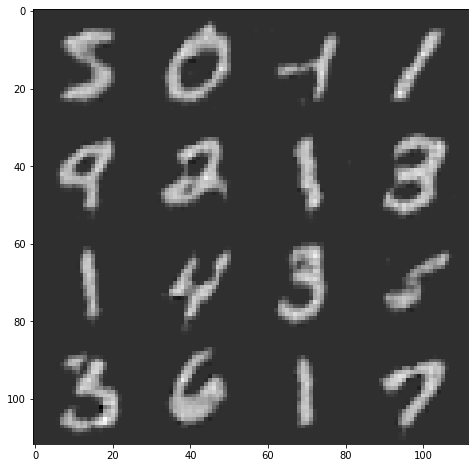

In [67]:
fake_image = AE(T_images.to(device))
show(make_grid(fake_image.cpu().detach(), nrow=4, padding=0, normalize=True, range=None, scale_each=False, pad_value=0))

## 进行可视化

In [52]:
from sklearn.manifold import TSNE

In [127]:
# 进行测试, 生成测试数据
for i, (datas, labels) in enumerate(test_loader):
    batch_size = images.size(0)
    datas = datas.to(device)
    x = AE.encoder(datas)
    x = x.cpu().detach().numpy().reshape(batch_size, -1)
    if i == 0:
        featureList = x
        labelsList = labels
    else: 
        featureList = np.append(featureList, x, axis=0)
        labelsList = np.append(labelsList, labels, axis=0)
    # if i == 3:
    #     break

In [128]:
featureList.shape, labelsList.shape

((10000, 24), (10000,))

In [129]:
# 降到2维
x_encode = TSNE(n_components=2).fit_transform(featureList) # 接着使用tSNE进行降维
print(x_encode.shape)

(10000, 2)


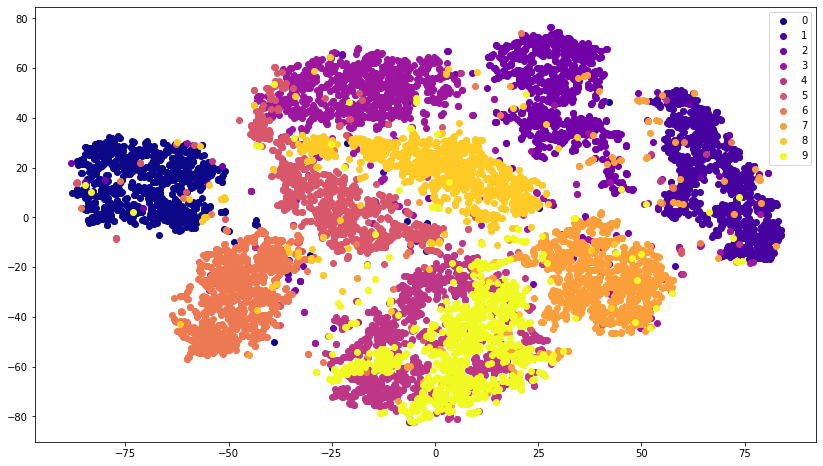

In [135]:
# 进行可视化
cmap = plt.get_cmap('plasma',10) # 数字与颜色的转换


# 获得可视化数据
v_x = x_encode
v_y = labelsList

# 进行可视化
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

classes = [0,1,2,3,4,5,6,7,8,9]

for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=cmap(key), label=key)

ax.legend()
plt.show()

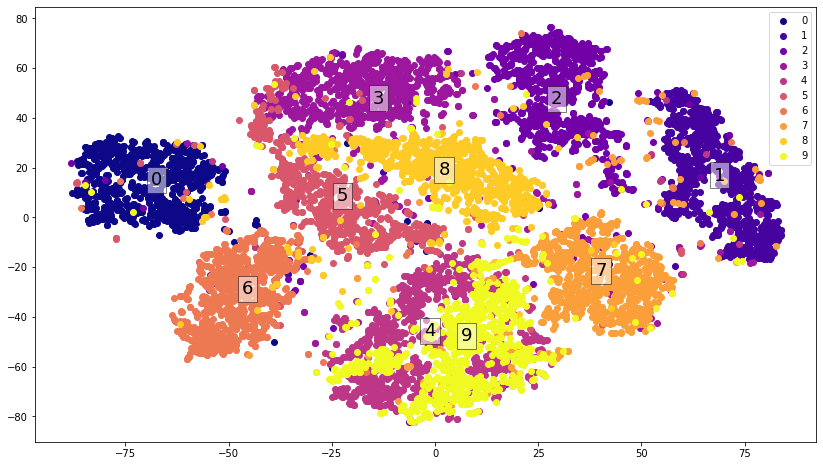

In [142]:
# 进行可视化
cmap = plt.get_cmap('plasma',10) # 数字与颜色的转换


# 获得可视化数据
v_x = x_encode
v_y = labelsList

# 进行可视化
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

classes = [0,1,2,3,4,5,6,7,8,9]

for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=cmap(key), label=key)
    ax.text(np.mean(v_x[ix][:,0]), np.mean(v_x[ix][:,1]), key, fontsize=18, bbox=dict(facecolor='white', alpha=0.5))

ax.legend()
plt.show()